## Sampling

In [ ]:
# get count numbers by source

from datetime import date, timedelta

import pandas as pd
from dateutil.relativedelta import relativedelta
from tqdm.notebook import tqdm

from src.data.news.config import (
    all_newspapers_with_id,
    local_newspapers,
    media_ids,
    newspapers_of_record,
    popular_newspapers,
)
from src.data.news.sources import engines

newspapers = [*newspapers_of_record, *popular_newspapers, *local_newspapers]

data = []
for newspaper in tqdm(newspapers):
    if newspaper[0] in [
        "merkur.de",
        "freiepresse.de",
        "shz.de",
        "ostsee-zeitung.de",
        "maz-online.de",
        "mz-web.de",
        "fr.de",
        "saarbruecker-zeitung.de",
        "schwaebische.de",
        "nordbayern.de",
    ]:
        continue
    for engine_name, engine in engines.items():
        print(newspaper, engine_name)
        for year in range(2013, 2022):
            for month in range(1, 13):
                # print(newspaper, engine_name, year, month)
                start_date = date(year, month, 1)
                end_date = start_date + relativedelta(months=1)
                articles = engine(
                    query=None,
                    date=start_date,
                    end_date=end_date,
                    newspaper=newspaper,
                )
                data.append(
                    dict(
                        newspaper=newspaper,
                        count=len(articles),
                        date=date(year, month, 1),
                        engine=engine_name,
                    )
                )
df_counts = pd.DataFrame(data)

In [ ]:
df_counts.to_csv("../../data/news/monthly_counts_prelim.csv", index=False)

In [ ]:
df_counts.head()

,newspaper,count,date,engine
0,welt.de,1,2013-01-01,mediacloud
1,welt.de,0,2013-02-01,mediacloud
2,welt.de,1,2013-03-01,mediacloud
3,welt.de,0,2013-04-01,mediacloud
4,welt.de,0,2013-05-01,mediacloud


/var/folders/6v/w9nn6c_n4qdbrjwfnq7695n00000gn/T/ipykernel_22288/4268709625.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_counts_zeit["date"] = df_counts_zeit["date"].apply(lambda d: d.strftime("%Y-%m"))
/var/folders/6v/w9nn6c_n4qdbrjwfnq7695n00000gn/T/ipykernel_22288/4268709625.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


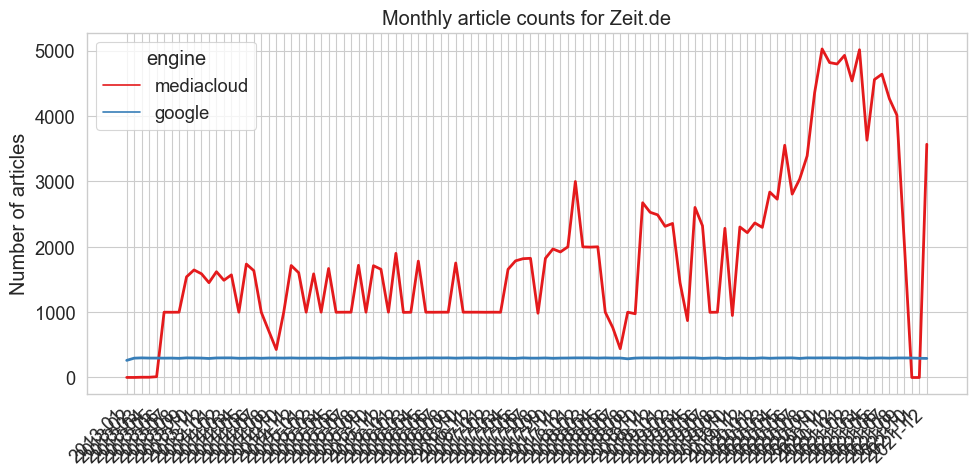

In [ ]:
# plot distribution of monthly counts for zeit.de

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.5)

df_counts_zeit = df_counts[df_counts["newspaper"] == "bild.de"]
df_counts_zeit["date"] = df_counts_zeit["date"].apply(lambda d: d.strftime("%Y-%m"))

fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(
    data=df_counts_zeit,
    x="date",
    y="count",
    hue="engine",
    ax=ax,
    palette="Set1",
    linewidth=2,
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_xlabel("")
ax.set_ylabel("Number of articles")
ax.set_title("Monthly article counts for Zeit.de")
plt.tight_layout()
plt.show()

In [ ]:
tradeoff_data = []
for newspaper, _ in newspapers:
    for source in ["mediacloud", "google"]:
        # get all monthly counts and sort them
        counts = (
            df_counts[
                (df_counts["newspaper"] == newspaper) & (df_counts["engine"] == source)
            ]
            .sort_values("count", ascending=False)["count"]
            .values
        )
        for count in counts:
            start_date = date(2021, 12, 1)
            while start_date.year > 2013:
                start_date_ = start_date - relativedelta(months=1)
                # get counts from month start_date_
                counts_ = df_counts[
                    (df_counts["newspaper"] == newspaper)
                    & (df_counts["engine"] == source)
                    & (df_counts["date"] == start_date_)
                ]  # ["count"].values
                print(counts_)
                break
                if counts_[0] < count:
                    tradeoff_data.append(
                        dict(
                            newspaper=newspaper,
                            source=source,
                            count=count,
                            date=start_date,
                        )
                    )
                    break
                start_date = start_date_
            break
        break
    break

df_tradeoff = pd.DataFrame(tradeoff_data)
df_tradeoff.head()

       newspaper  count        date      engine
106   spiegel.de      0  2021-11-01  mediacloud
2050  spiegel.de      0  2021-11-01  mediacloud


""


In [ ]:
# we want a uniform amount of articles per month for each newspaper
# since there is less coverage in earlier years, the earlier we  start, the less articles per month can we get uniformly
# here plot the tradeoff between start year and monthly number of articles for each newspaper

# convert count column to datetime
df_counts["date"] = pd.to_datetime(df_counts["date"])

tradeoff_data = []
end_year = 2022
for start_year in range(2013, end_year):
    for newspaper, _ in newspapers:
        for engine in ["mediacloud", "google"]:
            # get minimum number of articles per month
            df_part = df_counts[
                (df_counts["newspaper"] == newspaper)
                & (df_counts["date"].dt.year >= start_year)
                & (df_counts["date"].dt.year <= end_year)
                & (df_counts["engine"] == engine)
            ]
            min_count = df_part["count"].min()
            if min_count == 0 or pd.isna(min_count):
                continue
            n_months = (end_year - start_year) * 12
            tradeoff_data.append(
                dict(
                    newspaper=newspaper,
                    engine=engine,
                    start_year=start_year,
                    n_articles_per_month=min_count,
                    n_months=n_months,
                    n_articles=min_count * n_months,
                )
            )

df_tradeoff = pd.DataFrame(tradeoff_data)

# display more rows
pd.set_option("display.max_rows", 1000)

df_tradeoff = pd.DataFrame(tradeoff_data).sort_values(
    ["newspaper", "engine", "start_year"]
)
df_tradeoff

/var/folders/6v/w9nn6c_n4qdbrjwfnq7695n00000gn/T/ipykernel_22288/3616266378.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_total = df.groupby("start_year").sum().reset_index()


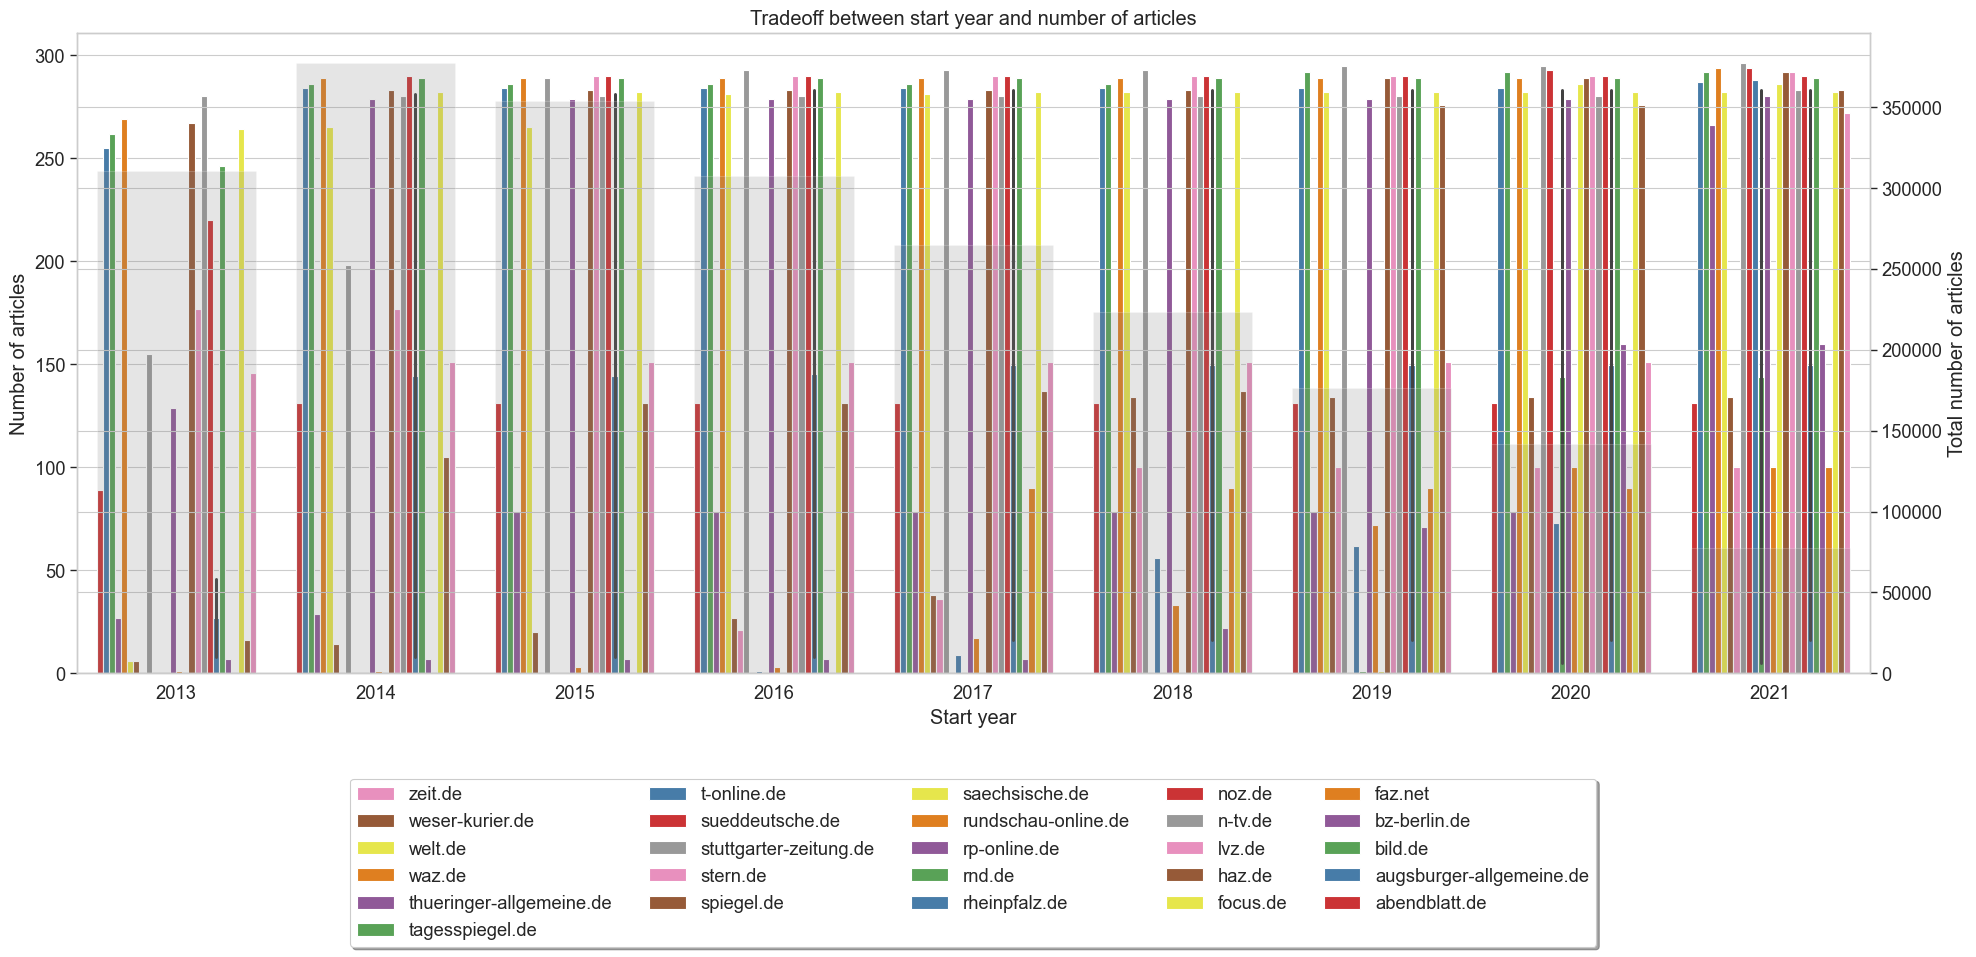

In [ ]:
df = df_tradeoff.copy()
df_total = df.groupby("start_year").sum().reset_index()

# create the same plot again but now use twinx to make an overlay with the total number of articles

fig, ax = plt.subplots(figsize=(20, 10))
sns.barplot(
    data=df,
    x="start_year",
    y="n_articles_per_month",
    hue="newspaper",
    ax=ax,
    palette="Set1",
)
ax.set_xlabel("Start year")
ax.set_ylabel("Number of articles")
ax.set_title("Tradeoff between start year and number of articles")

# put the legend below the plot and shrink it by 0.5 and reorder the items intelligently
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles[::-1],
    labels[::-1],
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    fancybox=True,
    shadow=True,
    ncol=5,
)

# create a second y axis
ax2 = ax.twinx()
sns.barplot(
    data=df_total, x="start_year", y="n_articles", ax=ax2, color="grey", alpha=0.2
)
ax2.set_ylabel("Total number of articles")

plt.tight_layout()
plt.show()

/var/folders/6v/w9nn6c_n4qdbrjwfnq7695n00000gn/T/ipykernel_22288/2072209339.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_total = df.groupby("start_year").sum().reset_index()


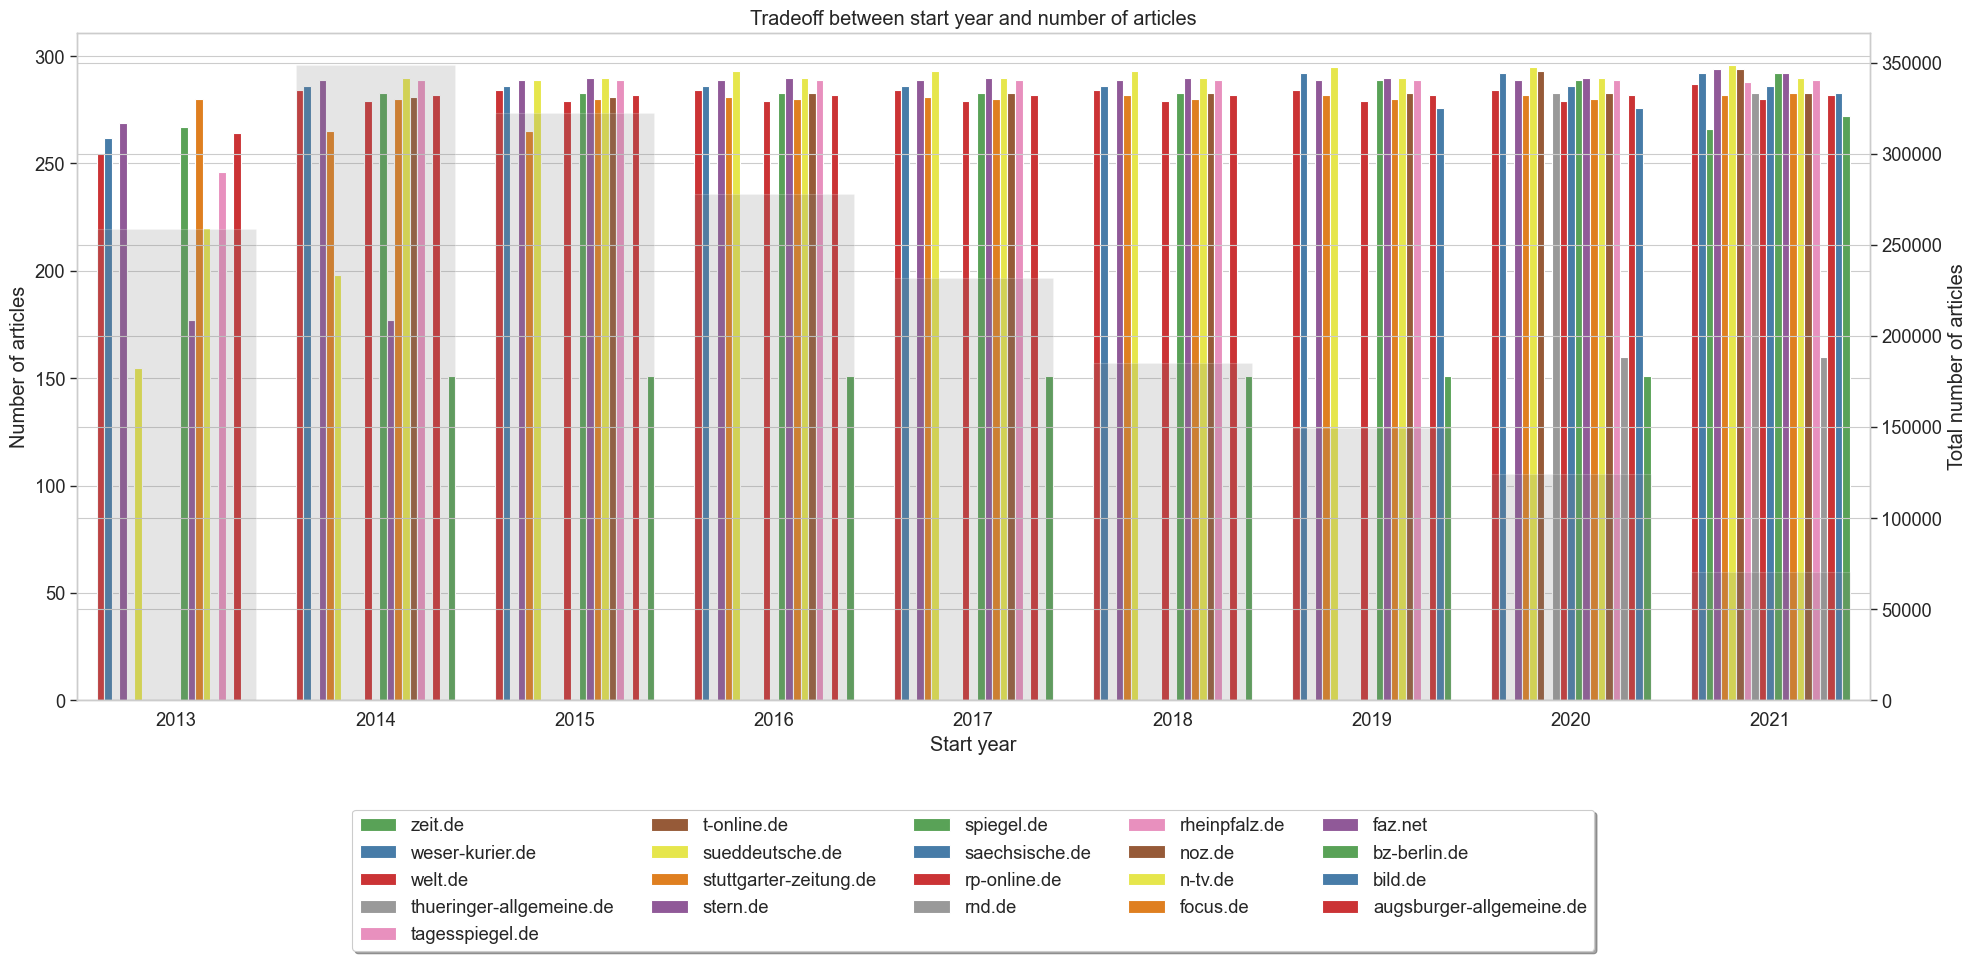

In [ ]:
df = df_tradeoff.copy()

# remove all entries with less than 150 articles per month
df = df[df["n_articles_per_month"] >= 150]

# recalculate the total number of articles per newspaper
df_total = df.groupby("start_year").sum().reset_index()

# plot again

fig, ax = plt.subplots(figsize=(20, 10))
sns.barplot(
    data=df,
    x="start_year",
    y="n_articles_per_month",
    hue="newspaper",
    ax=ax,
    palette="Set1",
)
ax.set_xlabel("Start year")
ax.set_ylabel("Number of articles")
ax.set_title("Tradeoff between start year and number of articles")

# put the legend below the plot and shrink it by 0.5 and reorder the items intelligently
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles[::-1],
    labels[::-1],
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    fancybox=True,
    shadow=True,
    ncol=5,
)

# create a second y axis
ax2 = ax.twinx()
sns.barplot(
    data=df_total, x="start_year", y="n_articles", ax=ax2, color="grey", alpha=0.2
)
ax2.set_ylabel("Total number of articles")

plt.tight_layout()
plt.show()

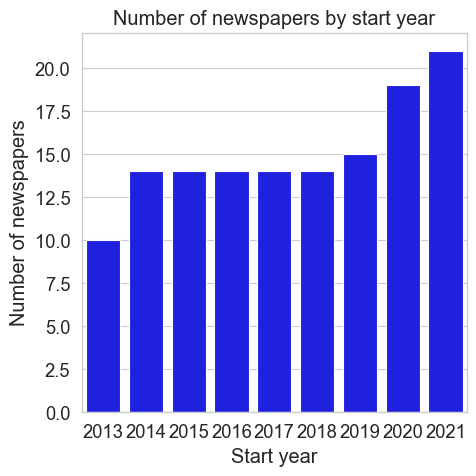

In [ ]:
df = df_tradeoff.copy()

# remove all entries with less than 150 articles per month
df = df[df["n_articles_per_month"] >= 150]

# plot the number of newspapers (that remain) by start_year
df_total = df.groupby("start_year").count().reset_index()

fig, ax = plt.subplots(figsize=(5, 5))
sns.barplot(data=df_total, x="start_year", y="newspaper", ax=ax, color="blue")
ax.set_xlabel("Start year")
ax.set_ylabel("Number of newspapers")
ax.set_title("Number of newspapers by start year")

plt.tight_layout()
plt.show()

In [ ]:
# grab data from 2014
df_2014 = df[df["start_year"] == 2014]